# Hello World Deep Learning in Medical Imaging

Code from the following [article](https://link.springer.com/article/10.1007/s10278-018-0079-6).

## Data prepration

Download data from the [GitHub repository](https://github.com/paras42/Hello_World_Deep_Learning/blob/9921a12c905c00a88898121d5dc538e3b524e520/Open_I_abd_vs_CXRs.zip), and unzip it to the folder of this notebook.

## Imports

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

In [2]:
# https://stackoverflow.com/questions/59340465/how-to-solve-no-algorithm-worked-keras-error
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Global variables

In [3]:
# dimensions of our images
img_width, img_height = 299, 299

# directory and image information
train_data_dir = 'Open_I_abd_vs_CXRs/TRAIN'
validation_data_dir = 'Open_I_abd_vs_CXRs/VAL'

# epochs = number of passes of through training data
# batch_size = number images processed at same time
train_samples = 65
validation_samples = 10
epochs = 20
batch_size = 5

## Build the model

Here, we use [Inception V3](https://keras.io/api/applications/inceptionv3/).

In [4]:
# build the Inception V3 network, use pretrained weights from ImageNet
# remove top fully connected layers by include_top=False
base_model = applications.InceptionV3(weights='imagenet',
                                      include_top=False,
                                      input_shape=(img_width, img_height, 3))

print(base_model)

### Add new layers on top of the model

In [5]:
# build a classifier model to put on top of the convolutional model
# This consists of a global average pooling layer and a fully connected layer with 256 nodes
# Then apply dropout and sigmoid activation
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:],
data_format=None)),
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))
model = Model(inputs=base_model.input, outputs=model_top(base_model.output))
# Compile model using Adam optimizer with common values and binary cross entropy loss
# Use low learning rate (lr) for transfer learning
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e08,decay=0.0), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])



Note that for classification tasks with greater than 2 classes (e.g., ImageNet has 1000 classes),
*categorical cross-entropy* is typically used as the loss function; for tasks with 2 classes (such as here), *binary cross-entropy* is used.

## Image Preprocessing and Augmentation

Preprocess and specify augmentation options, which include transformations and other variations to the image, which can help preempt overfitting or memorization of training data, and have shown to increase accuracy and generalization of CNNs.

While augmentation can be done inadvance, Keras has an image data generator, which can perform *on-the-fly* augmentation, such as rotations, translation, zoom, shearing, and flipping, just before they are fed to the network.

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, # Rescale pixel values to 0-1 to aid CNN processing
    shear_range=0.2, # 0-1 range for shearing
    zoom_range=0.2, # 0-1 range for zoom
    rotation_range=20, # 0-180 range, degrees of rotation
    width_shift_range=0.2, # 0-1 range horizontal translation
    height_shift_range=0.2, # 0-1 range vertical translation
    horizontal_flip=True) # set True or False

# Rescale pixel values to 0-1 to aid CNN processing
val_datagen = ImageDataGenerator(rescale=1./255)

## Defining the training and validation generator

In [7]:
# Directory, image size, batch size already specified above
# Class mode is set to 'binary' for a 2-class problem
# Generator randomly shuffles and presents images in batches to the network
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(validation_data_dir,
                                                         target_size=(img_height, img_width),
                                                         batch_size=batch_size,
                                                         class_mode='binary')

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


## Fitting the model

In [8]:
# Fine-tune the pretrained Inception V3 model using the data generator
# Specify steps per epoch (number of samples/batch_size)
history = model.fit(train_generator,
                    steps_per_epoch=train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_samples // batch_size)

Epoch 1/20
13/13 [==============================] - 14s 276ms/step - loss: 0.7998 - accuracy: 0.4773 - val_loss: 0.7165 - val_accuracy: 0.5000
Epoch 2/20
13/13 [==============================] - 3s 200ms/step - loss: 0.7988 - accuracy: 0.5021 - val_loss: 0.6604 - val_accuracy: 0.5000
Epoch 3/20
13/13 [==============================] - 3s 202ms/step - loss: 0.7225 - accuracy: 0.5497 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 4/20
13/13 [==============================] - 3s 203ms/step - loss: 0.7028 - accuracy: 0.5835 - val_loss: 0.6675 - val_accuracy: 0.5000
Epoch 5/20
13/13 [==============================] - 3s 204ms/step - loss: 0.7284 - accuracy: 0.5685 - val_loss: 0.7339 - val_accuracy: 0.5000
Epoch 6/20
13/13 [==============================] - 3s 209ms/step - loss: 0.8097 - accuracy: 0.4452 - val_loss: 0.7217 - val_accuracy: 0.5000
Epoch 7/20
13/13 [==============================] - 3s 212ms/step - loss: 0.6736 - accuracy: 0.5761 - val_loss: 0.6727 - val_accuracy: 0.7000
Epoch

### Plotting the model fitting convergence

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


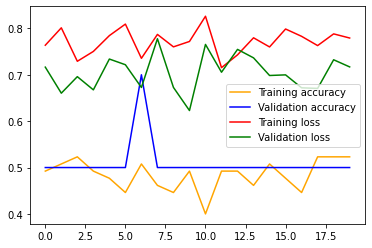

In [9]:
# import matplotlib library, and plot training cuve
import matplotlib.pyplot as plt

print(history.history.keys())
plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

## Evaluating the model performance

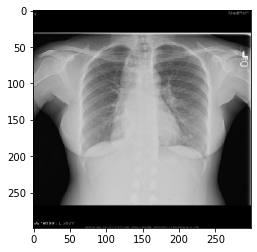

Predicted: [[0.7122253]] Abd X-ray


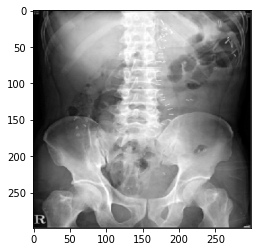

Predicted: [[0.6457654]] Abd X-ray


In [10]:
# import numpy and keras preprocessing libraries
import numpy as np
from keras.preprocessing import image

# load, resize, and display test images
img_path='Open_I_abd_vs_CXRs/TEST/chest2.png'
img_path2='Open_I_abd_vs_CXRs/TEST/abd2.png'
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))
plt.imshow(img)
plt.show()

# convert image to numpy array, so Keras can render a prediction
img = image.img_to_array(img)

# expand array from 3 dimensions (height, width, channels) to 4 dimensions (batch size, height, width, channels)
# rescale pixel values to 0-1
x = np.expand_dims(img, axis=0) * 1./255

# get prediction on test image
score = model.predict(x)

print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')
# display and render a prediction for the 2nd image
plt.imshow(img2)
plt.show()
img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')